# Dynamic Linear Model

Here we obtain a vanilla DLM by following the [pyro tutorial](http://pyro.ai/examples/forecasting_dlm.html). 

Also see these links:
- [Modelling mutivariate switching dynamics - advice on getting started?](https://forum.pyro.ai/t/modelling-mutivariate-switching-dynamics-advice-on-getting-started/4017/3)
- [Deep Markov Models](http://pyro.ai/examples/dmm.html#Guide)
- [Forecasting](https://docs.pyro.ai/en/stable/contrib.forecast.html)
- [Time series](https://docs.pyro.ai/en/stable/contrib.timeseries.html)
- [Enumeration of plates](https://pyro.ai/examples/enumeration.html)
- [HMM example](http://pyro.ai/examples/hmm.html)
- [Poutine](https://docs.pyro.ai/en/dev/poutine.html)

In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.ops.stats import quantile
from pyro.ops.tensor_utils import periodic_repeat


from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)

plt.style.use('seaborn-whitegrid')



## Data

Here we read data and aggregate on a daily level to easierly visualize the data.

In [23]:
# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)

# convert to torch tensors
X_W = torch.from_numpy(dfW.values).float()
X_E = torch.from_numpy(dfE.values).float()
obs = torch.from_numpy(df["price actual"].values).float()


# translate to pyro forecasting language
T = None # number of time steps to include, if None all data is used
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting

# start, train end, test end
T0 = 0
T1 = n - n//10 # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


## Model

In [24]:
class VanillaDLM(ForecastingModel):
    """
    model from http://pyro.ai/examples/forecasting_dlm.html
    """
    def __init__(self, use_priors = False):
        super().__init__()
        self.use_priors = use_priors
        self.time_points = np.concatenate((
            np.arange(300, 320),
            np.arange(600, 620),
            np.arange(900, 920),
        ))
        # broadcast on time-points
        betas = torch.empty(n, p).normal_(0, 0.02).cumsum(0)
        self.priors = betas[self.time_points]
        # print(self.priors.shape)
        
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            # print(t)
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))

        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace
        pyro.deterministic("weight", weight)

        # This is the only change from the simpler DLM model.
        # We inject prior terms as if they were likelihoods using pyro observe statements.
        if self.use_priors:
            for tp, prior in zip(self.time_points, self.priors):
                pyro.sample("weight_prior_{}".format(tp), dist.Normal(prior, 0.5).to_event(1), obs=weight[..., tp:tp+1, :])

        prediction = (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)

class SSM(ForecastingModel):
    """
    model from http://pyro.ai/examples/forecasting_ii.html?highlight=forecast
    """
    means = y[:T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).mean(0)
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)

        # We'll hard-code the periodic part of this model, learning only the local model.
        prediction = periodic_repeat(self.means, duration, dim=-1).unsqueeze(-1)
        # pyro.deterministic("prediction", prediction)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)

        timescale = pyro.sample("timescale", dist.LogNormal(np.log(24), 1))
        # Note timescale is a scalar but we need a 1x1 transition matrix (hidden_dim=1),
        # thus we unsqueeze twice using [..., None, None].
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * np.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)

        # Note the obs_matrix has shape hidden_dim x obs_dim = 1 x 1.
        obs_matrix = torch.tensor([[1.]])
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)
        

class Model(ForecastingModel):
    def __init__(self):
        super().__init__()
        self.M = 4
        self.h_dim = 10
        self.tau = 1
        self.gamma = 1
        self.lambda_g = 1
        self.lambda_f = 1
        self.sigma_beta = 1

        # sample season dependent variables
        with pyro.plate("season", self.M):
            sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau))
            R = pyro.sample("R", dist.HalfCauchy(self.gamma), sample_shape=(self.h_dim,)) 
            theta_g = pyro.sample("theta_g", dist.Normal(0, self.lambda_g), sample_shape=(self.h_dim,))
            theta_f = pyro.sample("theta_f", dist.Normal(0, self.lambda_f), sample_shape=(self.h_dim, X_E.shape[1] + X_W.shape[1] + self.h_dim))
            beta = pyro.sample("beta", dist.Normal(0, self.sigma_beta), sample_shape=(X_W.shape[1],))
            
        # permute parameters to have season in the first dimension
        print("R: ", R.shape, "theta_g: ", theta_g.shape, "theta_f: ", theta_f.shape, "beta: ", beta.shape)
        self.sigma = sigma
        self.R = R.permute(1, 0)
        self.theta_g = theta_g.permute(1, 0)
        self.theta_f = theta_f.permute(2, 1, 0)
        self.beta = beta.permute(1, 0)
        print("R: ", self.R.shape, "theta_g: ", self.theta_g.shape, "theta_f: ", self.theta_f.shape, "beta: ", self.beta.shape)

    def model(self, zero_data, covariates):
        duration, data_dim = zero_data.size()

        print(zero_data.shape, covariates.shape)

        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]

        # with self.time_plate:
        R = self.R
        theta_g = self.theta_g
        theta_f = self.theta_f
        beta = self.beta
        sigma = self.sigma
        

        # draw season variable 
        z = pyro.sample("z", dist.Categorical(logits=x_W @ beta.T))
        print("z: ", z.shape, z[:10])

        # time plate loop
        # with self.time_plate as t:
        #     # h0 = pyro.sample("h0", dist.Normal(torch.zeros(len(t), self.h_dim), torch.ones(len(t), self.h_dim)))
        #     # print("h0: ", h0.shape)
        #     h0 = torch.zeros(len(t), self.h_dim)
        #     c = torch.hstack((covariates, h0)).unsqueeze(1)
        #     print("c: ", c.shape)
        #     h_mean = (theta_f[z].T @ c).squeeze()
        #     h_var = R[z]
        #     h = pyro.sample("h", dist.Normal(h_mean, h_var))

        # h = pyro.sample("h_0", dist.Normal(0, 1), sample_shape=(self.h_dim,))
        h = pyro.sample("h_0", dist.Normal(torch.zeros(self.h_dim), torch.ones(self.h_dim)))
        print("h: ", h.shape, self.theta_g.shape, self.theta_f.shape, self.R.shape, self.sigma.shape)
        # for t in pyro.plate("time", duration):
        # # for t in self.time_plate:
        #     # Draw season variable zt ∼ Multinomial(zt |Softmax(XtW , β1 , . . . , βM ))
        #     print(x_E[t].shape, x_W[t].shape, h.shape)
        #     c = torch.concat((x_E[t], x_W[t], h)).unsqueeze(1)


        #     h_mean = (theta_f[z[t]].T @ c).squeeze()
        #     h_var = R[z[t]]
        #     h = pyro.sample(f"h_{t+1}", dist.Normal(h_mean, h_var))
        #     h = h.squeeze()

        # make prediction
        prediction = (theta_g[z] @ h).unsqueeze(-1)#.sum(-1, keepdim=True)
        print(prediction.shape)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)






## Inference

#### Train - can be skipped if you have a trained model

In [31]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = SSM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1], # only use energy data for SSM and Vanilla DLM
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

with open("models/latest_test_model.pkl", "wb") as f:
    pickle.dump(forecaster, f)

INFO 	 step    0 loss = 227.602
INFO 	 step  100 loss = 3.32074
INFO 	 step  200 loss = 3.32252
INFO 	 step  300 loss = 3.32164
INFO 	 step  400 loss = 3.32164
INFO 	 step  500 loss = 3.32162
INFO 	 step  600 loss = 3.32031
INFO 	 step  700 loss = 3.323
INFO 	 step  800 loss = 3.32064
INFO 	 step  900 loss = 3.32136


CPU times: total: 18.2 s
Wall time: 18.2 s


In [27]:
covariates.shape

torch.Size([1461, 10])

## Analyze posterior samples

In [32]:
pyro.set_rng_seed(1)

# load model
# f = pickle.load(open("vanilla_dlm.pkl", "rb")) # uncomment to load model

# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

posterior_samples["prediction"].shape

estimates_mean = posterior_samples["prediction"].mean(axis = 0)
estimates_median = posterior_samples["prediction"].median(axis = 0)
stds = posterior_samples["prediction"].std(axis = 0)

### Stats

In [33]:
resid = y - estimates_mean
# print("CRPS:", eval_crps(y.unsqueeze(0), estimates_mean.unsqueeze(0)))
print("Mean price: ", y.mean().round().item())
print("Mean price residuals within 2 std:", (resid - 2*stds).mean().round().item(), (resid + 2*stds).mean().round().item())
print("Mean price residuals:", resid.mean().round().item())

Mean price:  54.0
Mean price residuals within 2 std: -6.0 10.0
Mean price residuals: 2.0


In [37]:
posterior_samples["prediction"].shape

torch.Size([1461, 1])

### Plot

#### Predictive posteriors

ValueError: If using all scalar values, you must pass an index

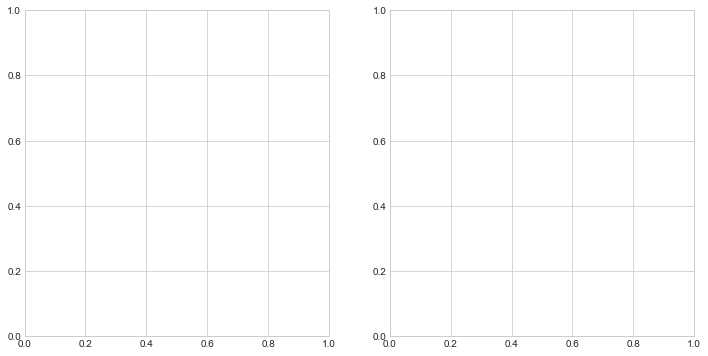

In [36]:
idx_test_example = torch.randint(low = T1, high=T2, size=(2,))
idx_train_example = torch.randint(low = T0, high=T1, size=(2,))
idxs = torch.hstack((idx_train_example, idx_test_example))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

pallete = sns.color_palette()

for i, idx in enumerate(idxs):
    if idx < T1:
        ax = axs[0]
        data_origin = "train"
    else:
        ax = axs[1]
        data_origin = "test"

    sns.kdeplot(posterior_samples["prediction"][:, idx].squeeze(), ax=ax, color=pallete[i], label="posterior")
    ax.axvline(y[idx].numpy(), color=pallete[i], label="true price", linestyle="--")
    ax.legend()

axs[0].set_title(f"Posterior predictive distribution for time steps {idx_train_example.detach().numpy().tolist()} (train)")
axs[1].set_title(f"Posterior predictive distribution for time steps {idx_test_example.detach().numpy().tolist()} (test)")

plt.show()

#### Forecasting

IndexError: slice() cannot be applied to a 0-dim tensor.

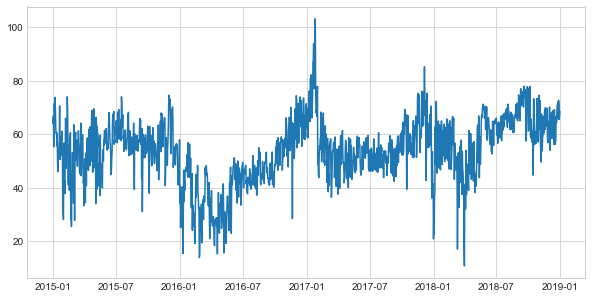

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))



# extract percentiles of the posterior samples
pred_p5, pred_p50, pred_p95 = quantile(posterior_samples['prediction'], (0.05, 0.5, 0.95)).squeeze(-1)

alpha = 1
ax.plot(dates, y, label="observed", alpha= alpha)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = alpha)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = alpha)
ax.fill_between(dates, pred_p5, pred_p95, color="red", alpha=.3, label = "90% prediction interval")
ax.legend()

ax.axvline(dates[T1], color='b', linestyle='--')


# plt.setp(ax.get_xticklabels(), rotation = 45)
fig.autofmt_xdate(rotation=45)

plt.show()